In [1]:
import logging
import pyvista as pv

from pointcept.supplemental.utils import *
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import (
    GridSplitter,
    plot_mesh_folds,
    crop_meshes_per_fold,
    save_fold_meshes
)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

set_data_root("../../data")
label = 'brass_foundry'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dh = DataHandler(label)
dh.ensure_meshes()

01:19:51 - INFO - Label brass_foundry already has extracted meshes.


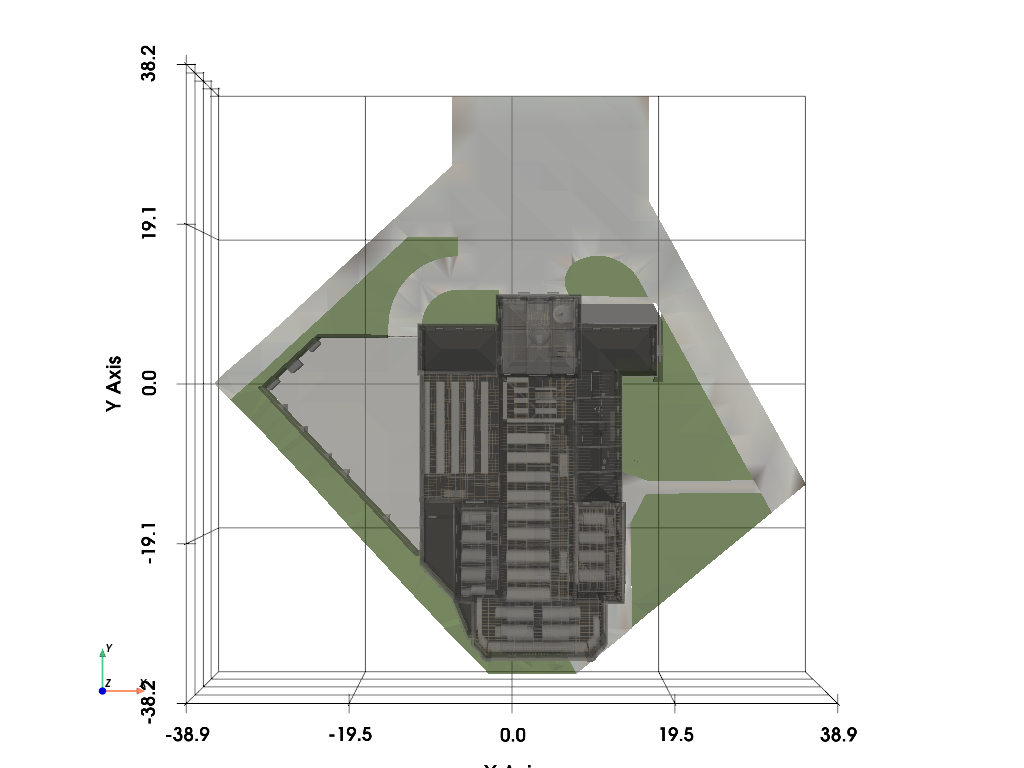

In [3]:
dh.plot_meshes()

In [4]:
analyser = MeshAnalyser(data_handler=dh)

In [5]:
to_exclude = []
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

01:19:56 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '6_GRASS', '7_COLUMN', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '12_RWP', '13_OTHER'].
01:19:56 - INFO - Sampling with resolution 0.15.
01:19:56 - INFO - Number of points after initial sampling: 1419913
01:19:56 - INFO - Number of points after Poisson Disk Sampling: 198406
01:19:56 - INFO - Number of points after initial sampling: 580373
01:19:57 - INFO - Number of points after Poisson Disk Sampling: 113364
01:19:57 - INFO - Number of points after initial sampling: 539115
01:19:57 - INFO - Number of points after Poisson Disk Sampling: 85507
01:19:57 - INFO - Number of points after initial sampling: 161107
01:19:57 - INFO - Number of points after Poisson Disk Sampling: 11796
01:19:57 - INFO - Number of points after initial sampling: 107781
01:19:57 - INFO - Number of points after Poisson Disk Sampling: 57169
01:19:57 - INFO - Number of points after initial sampli

In [6]:
binning = analyser.evaluate_binning(pcds, x_cell_width=6.0, y_cell_width=6.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

01:20:02 - INFO - Binning is using 13 bins in X and 13 bins in Y based on cell widths of 6.0 and 6.0.


01:44:25 - INFO - New best equality score: 1024000000000000020361855834783744.0000 at iteration 1
01:44:26 - INFO - New best equality score: 8220.3562 at iteration 15
01:44:27 - INFO - New best equality score: 5686.4332 at iteration 156
01:44:29 - INFO - Number of unique seed cell configurations = 500


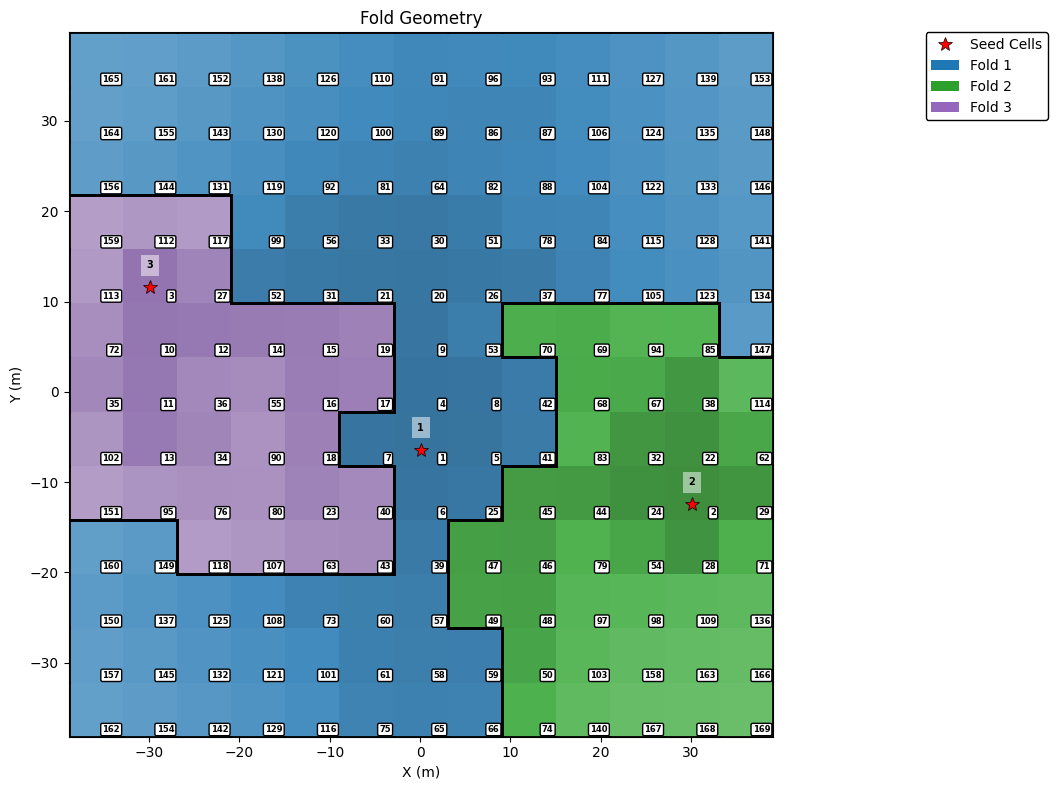

Iteration: 156

Fold Summaries:

Fold 1:
  Intended total counts: 423663.60
  Actual total counts: 421659.0
  Category Counts:
    1_WALL: 116994.0 (58.97% of total 1_WALL)
    2_FLOOR: 70399.0 (62.10% of total 2_FLOOR)
    3_ROOF: 53130.0 (62.14% of total 3_ROOF)
    4_CEILING: 8906.0 (75.50% of total 4_CEILING)
    5_FOOTPATH: 30483.0 (53.32% of total 5_FOOTPATH)
    6_GRASS: 10386.0 (31.32% of total 6_GRASS)
    7_COLUMN: 1777.0 (62.13% of total 7_COLUMN)
    8_DOOR: 3194.0 (66.35% of total 8_DOOR)
    9_WINDOW: 3033.0 (60.37% of total 9_WINDOW)
    10_STAIR: 2309.0 (62.68% of total 10_STAIR)
    11_RAILING: 4074.0 (56.63% of total 11_RAILING)
    12_RWP: 991.0 (48.82% of total 12_RWP)
    13_OTHER: 115983.0 (64.05% of total 13_OTHER)
  Aspect Ratio: 1.00

Fold 2:
  Intended total counts: 141221.20
  Actual total counts: 150227.0
  Category Counts:
    1_WALL: 35803.0 (18.05% of total 1_WALL)
    2_FLOOR: 24840.0 (21.91% of total 2_FLOOR)
    3_ROOF: 19113.0 (22.35% of total 3_ROOF)

In [36]:
weights = {1: 0.6, 2: 0.2, 3: 0.2}  # Intended area weights: training, evaluation, test
region_counts = {1: 1, 2: 1, 3: 1}
iterations = 500  # Number of iterations to run

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    region_counts=region_counts,
)
grid_splitter.min_percentage_threshold = 10.0

# Run the algorithm
grid_splitter.run()

# Access the best configuration
best_config = grid_splitter.best_configuration

# Plot the result
best_config.plot()

# Print the summary
best_config.print_summary()

01:44:47 - INFO - Fold 1, Region 1: Found 10 rectangles with total perimeter 104


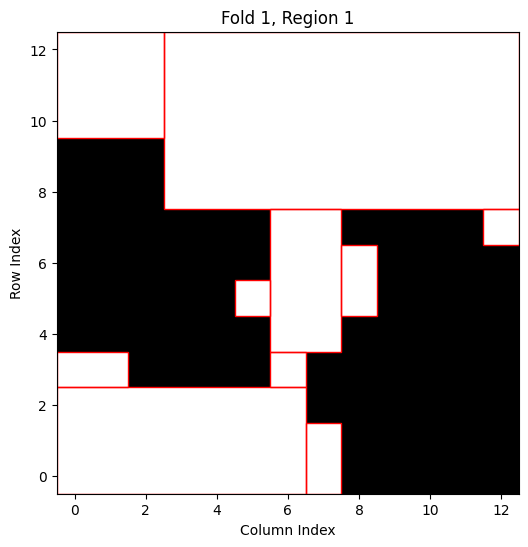

01:44:47 - INFO - Fold 2, Region 2: Found 4 rectangles with total perimeter 50


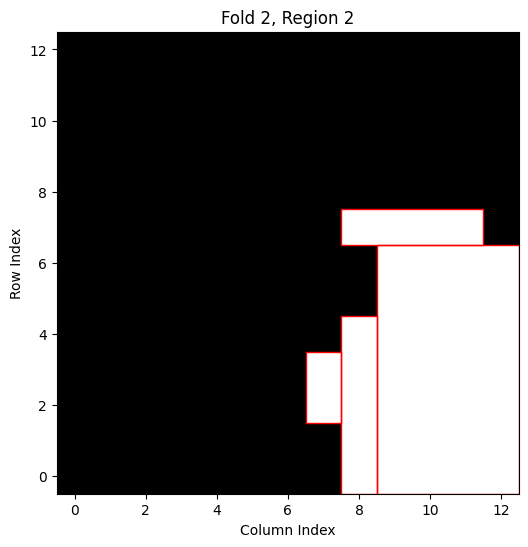

01:44:47 - INFO - Fold 3, Region 3: Found 5 rectangles with total perimeter 48


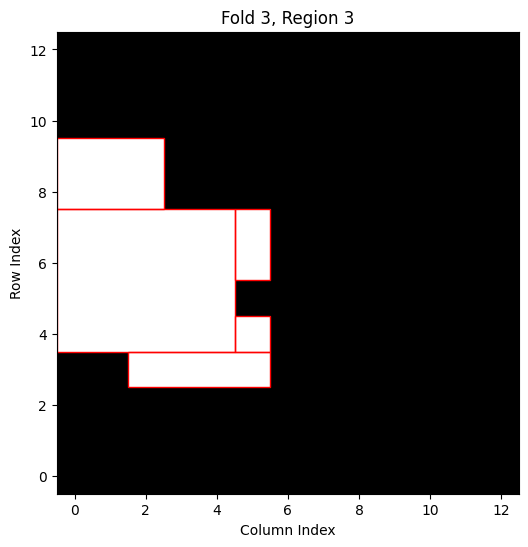

In [37]:
fold_rectangles = best_config.generate_fold_rectangles(combine_subregions=False)

In [38]:
fold_meshes = crop_meshes_per_fold(
    dh.extracted_meshes,
    fold_rectangles,
    best_config.x_edges,
    best_config.y_edges,
)

01:44:48 - INFO - Processing Region 1 in Fold 1
01:48:46 - INFO - Processing Region 2 in Fold 2
01:49:25 - INFO - Processing Region 3 in Fold 3


In [40]:
plot_mesh_folds(fold_meshes, backend='trame', cmap='tab20')

Widget(value='<iframe src="http://localhost:34751/index.html?ui=P_0x7a010177cb90_5&reconnect=auto" class="pyvi…

In [41]:
best_config.save(f"../../fold_allocations/{label}_v1.pkl")

In [43]:
save_fold_meshes(dh, fold_meshes)

01:55:27 - INFO - Saved Fold 1, Region 1, Category '1_WALL' to ../../data/meshes/extracted/brass_foundry/train/1_wall_sceneid1.ply.
01:55:27 - INFO - Saved Fold 1, Region 1, Category '2_FLOOR' to ../../data/meshes/extracted/brass_foundry/train/2_floor_sceneid1.ply.
01:55:27 - INFO - Saved Fold 1, Region 1, Category '3_ROOF' to ../../data/meshes/extracted/brass_foundry/train/3_roof_sceneid1.ply.
01:55:27 - INFO - Saved Fold 1, Region 1, Category '4_CEILING' to ../../data/meshes/extracted/brass_foundry/train/4_ceiling_sceneid1.ply.
01:55:27 - INFO - Saved Fold 1, Region 1, Category '5_FOOTPATH' to ../../data/meshes/extracted/brass_foundry/train/5_footpath_sceneid1.ply.
01:55:27 - INFO - Saved Fold 1, Region 1, Category '6_GRASS' to ../../data/meshes/extracted/brass_foundry/train/6_grass_sceneid1.ply.
01:55:27 - INFO - Saved Fold 1, Region 1, Category '7_COLUMN' to ../../data/meshes/extracted/brass_foundry/train/7_column_sceneid1.ply.
01:55:27 - INFO - Saved Fold 1, Region 1, Category '8_